# Astra International (ASII.JK) Stock Price Prediction using LSTM

In this project, we will try to predict the stock price of PT. Astra International Tbk (Astra).

## 1. Business Understanding

Astra is an Indonesian conglomerate (Indonesia-investment.com, 2014). This company was established in 1957 in Jakarta as a general trading company. In 1990, Astra has listed its shares on the Indonesia Stock Exchange under the ticker code ASII (Astra.co.id, 2021).

The objective of this project is to accurately predict Astra stock price.

Since stock price data is time-series data, it is essential to use a model that can predict time-series data accurately. Several popular models can be used to predict time-series data such as Long Short-Term Memory (LSTM) Network, Autoregressive Integrated Moving Average (ARIMA), and Facebook Prophet. For instance, Bao et al. implemented LSTM model for stock price forecasting (Bao et al, 2017), Pai and Lin used ARIMA and Support Vector Machines (SVM) model in stock price forecasting (Pai and Lin, 2004), Papacharalampous et al. implemented a Facebook Prophet for time-series forecasting (Papacharalampous et al, 2018). However, in this simple project, we will use LSTM to predict the stock price.

The LSTMs have recurrent connections; thus, the state of previous activations of the neuron from the previous time step is used as context for formulating an output (Brownlee, 2017). Besides, unlike other RNNs, LSTM has a unique formulation that allows it to avoid the problems that prevent the training and scaling of other RNNs. Therefore, it can achieve a better result. Those are the reasons why LSTM is gaining a lot of popularity for solving the time-series prediction case.

Are you ready? Let's predict ASII stock price! Note that we will use the LSTM model and the CRISP-DM reference model (adapted) as guidance to predict the ASII.JK stock price.

## 2. Data Acquisition

How to get the dataset? You can download the historical data on yahoo finance. Here's the link to access the ASII stock price: https://finance.yahoo.com/quote/ASII.JK?p=ASII.JK&.tsrc=fin-srch

1. Click on the "Historical Data" to see all the ASII stock price data.
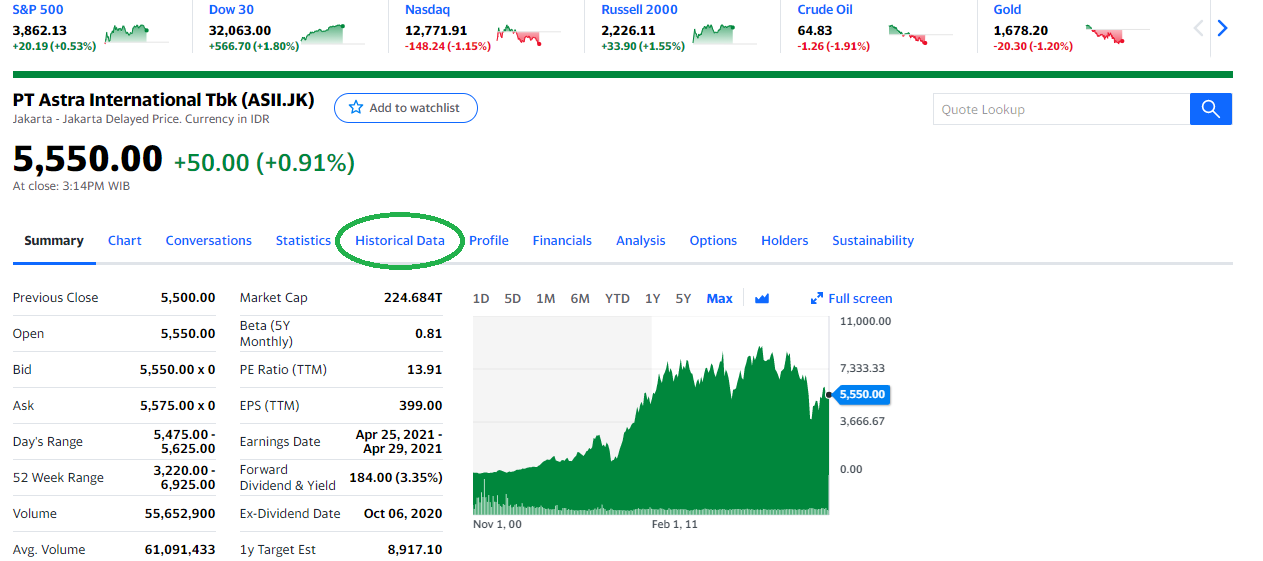

2. Chose the time period as "MAX". 
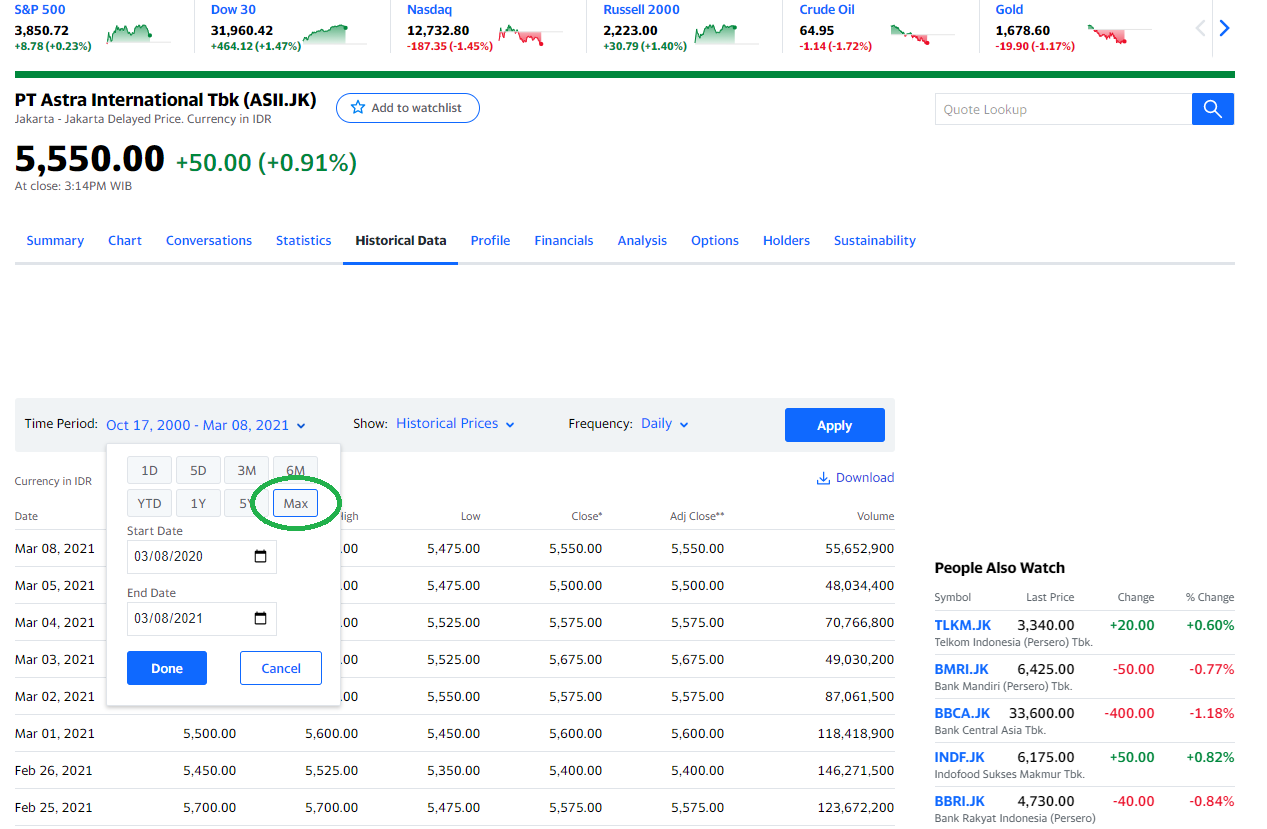

3. Show the "Historical Prices"
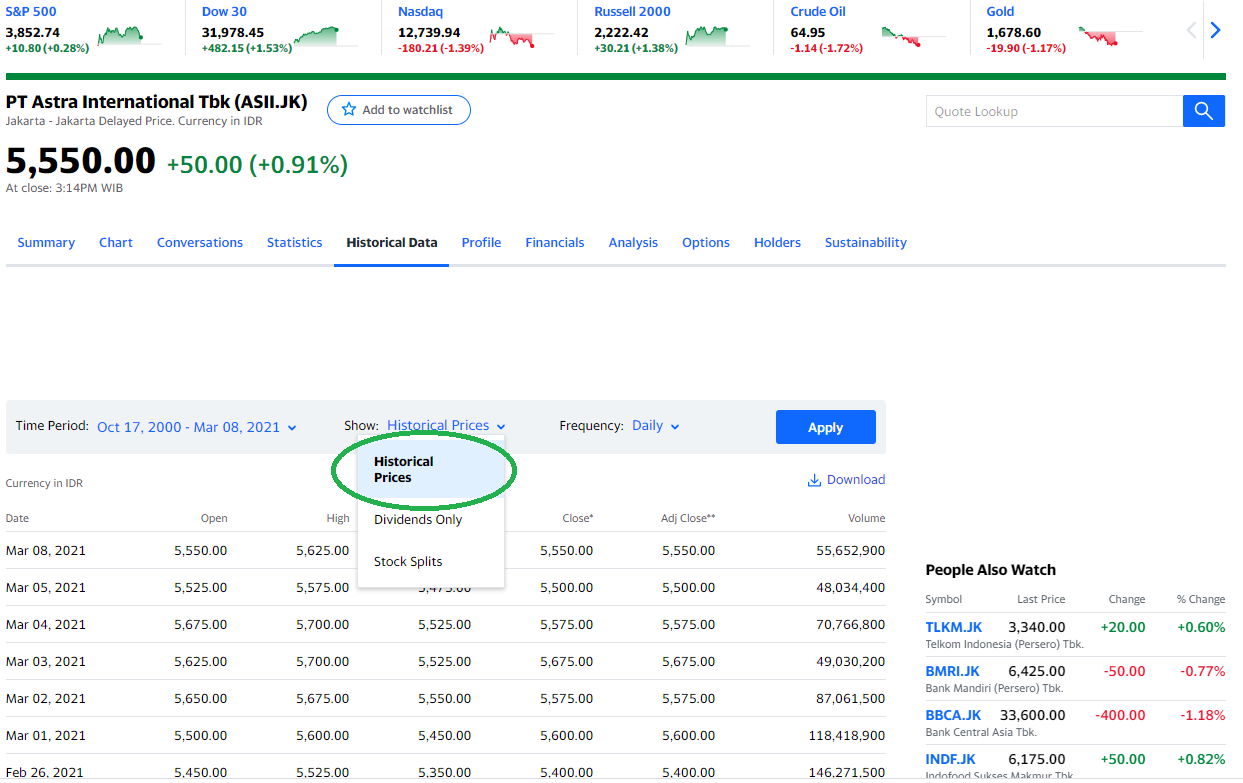

4. Show frequency data in "Daily". Thus, it will provide the stock price of ASII until the latest day on daily basis.
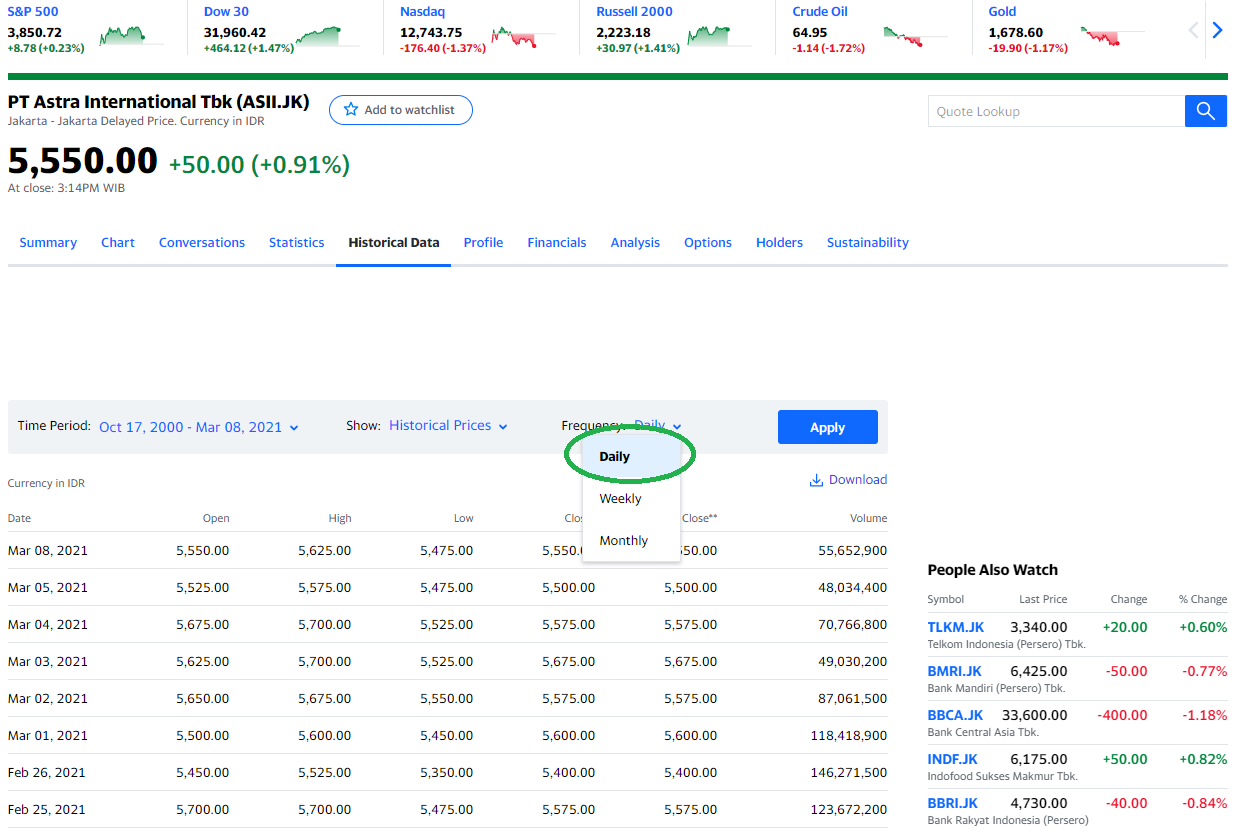

5. Click "Download". Voila! Now the download process is progressing.
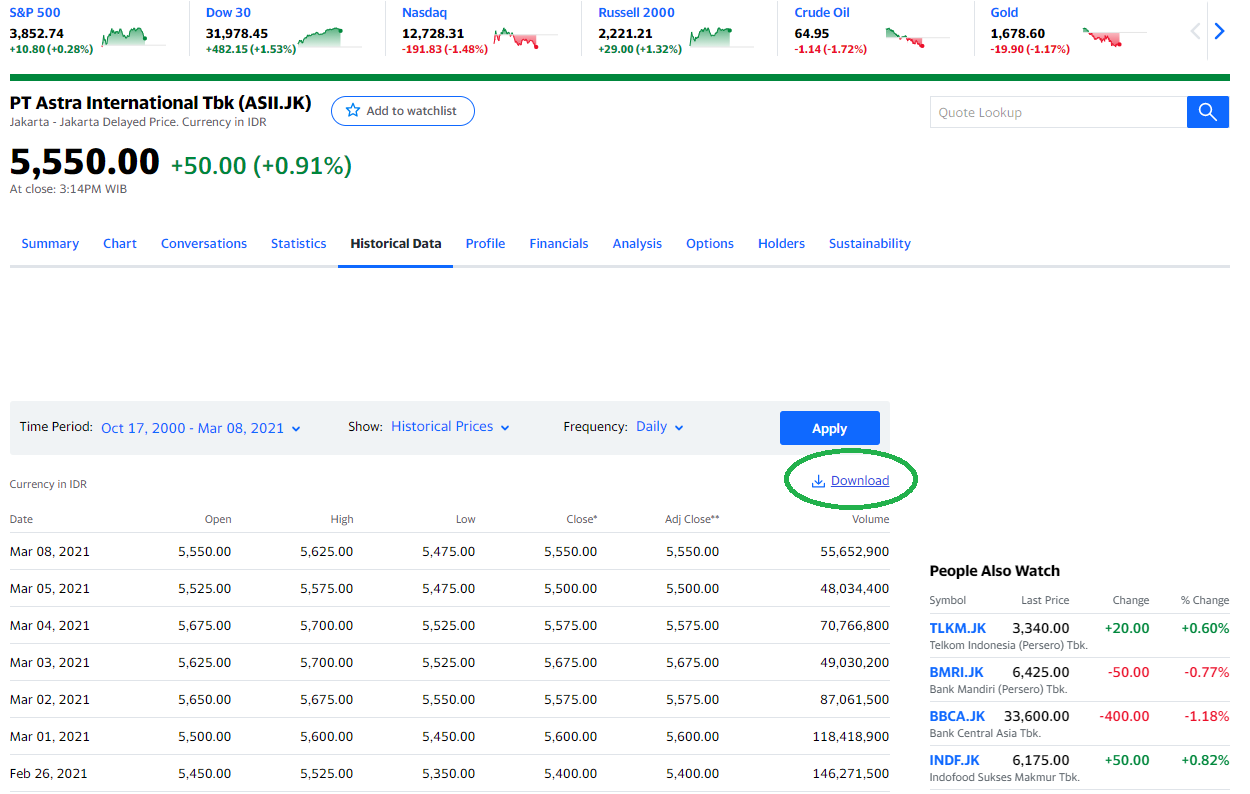

After the download is finished, you will have the .csv file containing data such as date, open, high, low, close, adj close, and volume.

Note that in this project I use ASII stock price data from 17th of October 2000 until 5th of March 2021. The pictures above mentioned only illustrate the process of data acquisition.

Now we have the dataset. Let's explore this dataset!

## 3. Data Understanding

In [1]:
#import the libraries
import matplotlib.pyplot as plt
import keras
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping

%matplotlib inline
pd.set_option('display.max_columns', None)

# Data viz by using Plotly
import plotly.express as px
import plotly.graph_objects as go

# ignore warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

Using TensorFlow backend.


In [2]:
# importing the dataset
inputdir = 'asiistockprice' #data was donloaded on 8 Mar 2021
#asii = pd.read_csv('ASII.JK.csv')
asii = pd.read_csv(inputdir+'/ASII.JK.csv')

In [3]:
# cheking missing values
asii[asii.isnull().any(axis=1)]

Date  Open  High  Low  Close  Adj Close  Volume
4688  2019-06-19   NaN   NaN  NaN    NaN        NaN     NaN

In [4]:
# identify how many missing values in each feature
asii.isnull().sum()

Date         0
Open         1
High         1
Low          1
Close        1
Adj Close    1
Volume       1
dtype: int64

In [5]:
# drop missing values from the dataset
asii = asii.dropna()

In [6]:
# check the shape of dataset
asii.shape

(5110, 7)

In [7]:
# check the dataset
asii.tail()

Date    Open    High     Low   Close  Adj Close       Volume
5106  2021-03-01  5500.0  5600.0  5450.0  5600.0     5600.0  118418900.0
5107  2021-03-02  5650.0  5675.0  5550.0  5575.0     5575.0   87061500.0
5108  2021-03-03  5625.0  5700.0  5525.0  5675.0     5675.0   49030200.0
5109  2021-03-04  5675.0  5700.0  5525.0  5575.0     5575.0   70766800.0
5110  2021-03-05  5525.0  5575.0  5475.0  5500.0     5500.0   48034400.0

In [8]:
# check the info of dataset
asii.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5110 entries, 0 to 5110
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       5110 non-null   object 
 1   Open       5110 non-null   float64
 2   High       5110 non-null   float64
 3   Low        5110 non-null   float64
 4   Close      5110 non-null   float64
 5   Adj Close  5110 non-null   float64
 6   Volume     5110 non-null   float64
dtypes: float64(6), object(1)
memory usage: 319.4+ KB


In [9]:
# describe of the dataset
asii.describe()

Open         High          Low        Close    Adj Close  \
count  5110.000000  5110.000000  5110.000000  5110.000000  5110.000000   
mean   4164.369534  4214.692055  4110.037662  4162.452002  3487.004051   
std    3058.450393  3088.898983  3023.776667  3056.231198  2762.520885   
min      86.940796    90.804832    85.008781    88.872810    50.086323   
25%    1020.000000  1035.000000  1000.000000  1015.000000   625.521606   
50%    4815.000000  4870.000000  4730.000000  4810.000000  3756.409790   
75%    7100.000000  7157.500000  7000.000000  7098.750000  6073.216797   
max    9250.000000  9350.000000  8975.000000  9150.000000  8269.624023   

             Volume  
count  5.110000e+03  
mean   6.330208e+07  
std    1.271598e+08  
min    0.000000e+00  
25%    1.682555e+07  
50%    3.221595e+07  
75%    6.107175e+07  
max    2.485057e+09

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001EE72F7B848>,
      dtype=object)

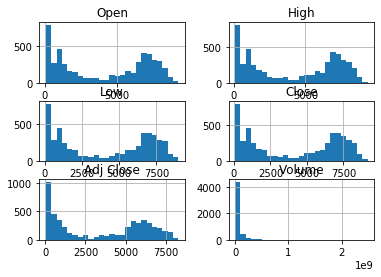

In [10]:
# checking the features
asii.hist(bins=25)

In [11]:
# format the raw date feature into a measureable format
asii['Date'] = pd.to_datetime(asii['Date'], format="%Y-%m-%dT%H:%M:%S")

In [12]:
# check the dataset
asii.head()

Date        Open        High         Low       Close   Adj Close  \
0 2000-10-17  189.724136  192.815369  187.405716  187.792114  105.834579   
1 2000-10-18  187.792114  188.951324  181.609665  181.996063  102.568069   
2 2000-10-19  183.928085  187.405716  179.291245  186.246506  104.963516   
3 2000-10-20  193.201767  195.133789  175.813614  177.745636  100.172661   
4 2000-10-23  177.745636  181.609665  173.881592  175.813614   99.083794   

        Volume  
0   30266285.0  
1   45082402.0  
2   43730189.0  
3  212012808.0  
4   84723602.0

In [13]:
# visualize the dataset by using Plotly
fig = go.Figure(data=[go.Candlestick(x= asii['Date'],
                open= asii['Open'], high= asii['High'],
                low= asii['Low'], close= asii['Close'])
                      ])

fig.update_layout(
    title='ASII.JK Stock Price',
    yaxis_title='ASII Stock',
    shapes = [dict(
        x0='2020-01-27', x1='2020-01-27', y0=0, y1=1, xref='x', yref='paper',
        line_width=2)],
    annotations=[dict(
        x='2020-01-27', y=0.05, xref='x', yref='paper',
        showarrow=False, xanchor='right', text='Increase Period Begins')]
)

fig.update_yaxes(title_text = 'Stock Price', tickprefix = 'IDR ')

fig.show()

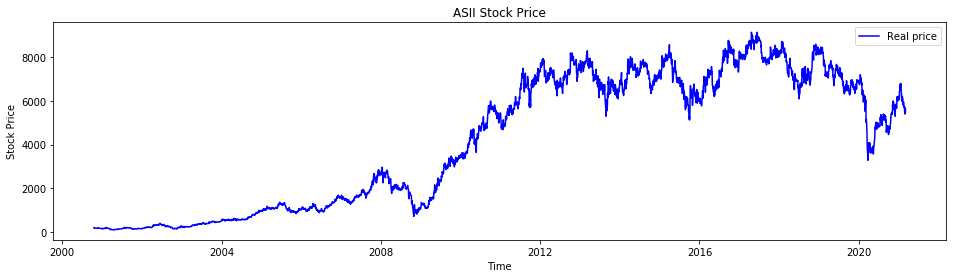

In [14]:
# Visualize the dataset by using Matplotlib
fig, ax = plt.subplots(figsize=(16, 4))
plt.plot(asii['Date'], asii['Close'], color = 'blue', label = 'Real price')
plt.title('ASII Stock Price')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

By implementing this kind of data visualization, we can see when the stock price tends to increase or decrease. It helps us to find out the root causes if the market is volatile. In addition, we can select the point that we want to observe.

## 4. Data Preparation

We will use the 'Close' stock price of ASII.JK

In [15]:
# select the train set and test set
train_set = asii.iloc[:4500, 4:5].values 
test_set = asii.iloc[4500:, 4:5].values 

In [16]:
# checking the train set
train_set

array([[ 187.792114],
       [ 181.996063],
       [ 186.246506],
       ...,
       [7200.      ],
       [7350.      ],
       [7375.      ]])

In [17]:
# Feature Scaling
sc = MinMaxScaler(feature_range = (0, 1))
train_set_scaled = sc.fit_transform(train_set)

In [18]:
# Creating a data structure of train set
X_train = []
y_train = []

for i in range(60, 4500):
    X_train.append(train_set_scaled[i-50:i, 0])
    y_train.append(train_set_scaled[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

In [19]:
# Creating a data structure of test set
dataset_train = asii.iloc[:4500, 4:5]
dataset_test = asii.iloc[4500:, 4:5]

dataset_total = pd.concat((dataset_train, dataset_test), axis = 0)

inputs = dataset_total[len(dataset_total) - len(dataset_test) - 60:].values
inputs = inputs.reshape(-1,1)
inputs = sc.transform(inputs)

X_test = []
y_test = []

for i in range(60, 670):
    X_test.append(inputs[i-50:i, 0])
    y_test.append(inputs[i, 0])
    
X_test, y_test = np.array(X_test), np.array(y_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
print(X_test.shape)

(610, 50, 1)


## 5. Modelling and Validation

In [20]:
model = Sequential()

n_unit = 100

#Adding the first LSTM layer and some Dropout regularisation
model.add(LSTM(units = n_unit, return_sequences = True, input_shape = (X_train.shape[1], 1)))
model.add(Dropout(0.2))

# Adding a second LSTM layer and some Dropout regularisation
model.add(LSTM(units = n_unit, return_sequences = True))
model.add(Dropout(0.2))

# Adding a third LSTM layer and some Dropout regularisation
model.add(LSTM(units = n_unit, return_sequences = True))
model.add(Dropout(0.2))

# Adding a fourth LSTM layer and some Dropout regularisation
model.add(LSTM(units = n_unit))
model.add(Dropout(0.2))

# Adding the output layer
model.add(Dense(units = 1))

# Compiling the RNN
model.compile(optimizer = 'adam', loss = 'mean_squared_error', metrics=['mae', 'mse','accuracy'])

In [21]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 50, 100)           40800     
_________________________________________________________________
dropout_1 (Dropout)          (None, 50, 100)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 50, 100)           80400     
_________________________________________________________________
dropout_2 (Dropout)          (None, 50, 100)           0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 50, 100)           80400     
_________________________________________________________________
dropout_3 (Dropout)          (None, 50, 100)           0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 100)              

In [22]:
# Fitting the LSTM Network to the Training set
history = model.fit(X_train, y_train, epochs = 100, batch_size = 32, validation_data=(X_test, y_test))

Train on 4440 samples, validate on 610 samples
Epoch 1/100
4440/4440 [==============================] - 20s 5ms/step - loss: 0.0097 - mae: 0.0542 - mse: 0.0097 - accuracy: 9.0090e-04 - val_loss: 0.0026 - val_mae: 0.0377 - val_mse: 0.0026 - val_accuracy: 0.0000e+00
Epoch 2/100
4440/4440 [==============================] - 18s 4ms/step - loss: 0.0024 - mae: 0.0322 - mse: 0.0024 - accuracy: 9.0090e-04 - val_loss: 0.0027 - val_mae: 0.0391 - val_mse: 0.0027 - val_accuracy: 0.0000e+00
Epoch 3/100
4440/4440 [==============================] - 18s 4ms/step - loss: 0.0021 - mae: 0.0306 - mse: 0.0021 - accuracy: 9.0090e-04 - val_loss: 0.0025 - val_mae: 0.0385 - val_mse: 0.0025 - val_accuracy: 0.0000e+00
Epoch 4/100
4440/4440 [==============================] - 18s 4ms/step - loss: 0.0020 - mae: 0.0299 - mse: 0.0020 - accuracy: 9.0090e-04 - val_loss: 0.0026 - val_mae: 0.0393 - val_mse: 0.0026 - val_accuracy: 0.0000e+00
Epoch 5/100
4440/4440 [==============================] - 18s 4ms/step - loss: 0.0

4440/4440 [==============================] - 18s 4ms/step - loss: 9.8993e-04 - mae: 0.0235 - mse: 9.8993e-04 - accuracy: 9.0090e-04 - val_loss: 4.5817e-04 - val_mae: 0.0158 - val_mse: 4.5817e-04 - val_accuracy: 0.0000e+00
Epoch 38/100
4440/4440 [==============================] - 17s 4ms/step - loss: 0.0010 - mae: 0.0244 - mse: 0.0010 - accuracy: 9.0090e-04 - val_loss: 4.9564e-04 - val_mae: 0.0167 - val_mse: 4.9564e-04 - val_accuracy: 0.0000e+00
Epoch 39/100
4440/4440 [==============================] - 18s 4ms/step - loss: 8.9863e-04 - mae: 0.0223 - mse: 8.9863e-04 - accuracy: 9.0090e-04 - val_loss: 6.9170e-04 - val_mae: 0.0205 - val_mse: 6.9170e-04 - val_accuracy: 0.0000e+00
Epoch 40/100
4440/4440 [==============================] - 18s 4ms/step - loss: 8.9380e-04 - mae: 0.0226 - mse: 8.9380e-04 - accuracy: 9.0090e-04 - val_loss: 7.3532e-04 - val_mae: 0.0213 - val_mse: 7.3532e-04 - val_accuracy: 0.0000e+00
Epoch 41/100
4440/4440 [==============================] - 18s 4ms/step - loss: 9.

4440/4440 [==============================] - 18s 4ms/step - loss: 7.5872e-04 - mae: 0.0211 - mse: 7.5872e-04 - accuracy: 9.0090e-04 - val_loss: 4.9503e-04 - val_mae: 0.0175 - val_mse: 4.9503e-04 - val_accuracy: 0.0000e+00
Epoch 73/100
4440/4440 [==============================] - 18s 4ms/step - loss: 7.5816e-04 - mae: 0.0210 - mse: 7.5816e-04 - accuracy: 9.0090e-04 - val_loss: 6.1992e-04 - val_mae: 0.0208 - val_mse: 6.1992e-04 - val_accuracy: 0.0000e+00
Epoch 74/100
4440/4440 [==============================] - 18s 4ms/step - loss: 7.5863e-04 - mae: 0.0211 - mse: 7.5863e-04 - accuracy: 9.0090e-04 - val_loss: 3.8151e-04 - val_mae: 0.0149 - val_mse: 3.8151e-04 - val_accuracy: 0.0000e+00
Epoch 75/100
4440/4440 [==============================] - 18s 4ms/step - loss: 6.9409e-04 - mae: 0.0202 - mse: 6.9409e-04 - accuracy: 9.0090e-04 - val_loss: 3.4235e-04 - val_mae: 0.0140 - val_mse: 3.4235e-04 - val_accuracy: 0.0000e+00
Epoch 76/100
4440/4440 [==============================] - 18s 4ms/step - 

In [23]:
# Getting the predicted stock price
predicted_stock_price = model.predict(X_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

In [24]:
# check the prediction shape
predicted_stock_price.shape

(610, 1)

In [25]:
# check the test set shape
dataset_test.values.shape

(610, 1)

In [26]:
# create a new dataframe for visualization
date = pd.DataFrame(asii['Date'][4500:])
test_value = pd.DataFrame(dataset_test.values, columns=['Real price'])
pred_value = pd.DataFrame(predicted_stock_price, columns=['Predicted price']) 

In [27]:
# reset index
date = date.reset_index()

In [28]:
# combine the desired value into one dataframe
pred_stock = pd.concat([date, test_value, pred_value], axis=1)
pred_stock = pred_stock.drop(columns=['index'])
pred_stock

Date  Real price  Predicted price
0   2018-09-28      7350.0      7505.325684
1   2018-10-01      7325.0      7492.707031
2   2018-10-02      7200.0      7483.139160
3   2018-10-03      7200.0      7397.719727
4   2018-10-04      7075.0      7384.062012
..         ...         ...              ...
605 2021-03-01      5600.0      5531.662109
606 2021-03-02      5575.0      5636.507324
607 2021-03-03      5675.0      5662.985840
608 2021-03-04      5575.0      5738.117188
609 2021-03-05      5500.0      5686.202637

[610 rows x 3 columns]

In [29]:
# visualize the stock price prediction by using Plotly
fig = px.line(pred_stock, x = 'Date', y = pred_stock.columns,
              hover_data={'Date': '|%B %d, %Y'},
              title='ASII.JK Stock Price Prediction')

fig.update_xaxes(
    dtick='M1',
    tickformat='%b\n%Y',
    ticklabelmode='period')

fig.update_yaxes(title_text = 'Stock Price', tickprefix = 'IDR ')

fig.show()

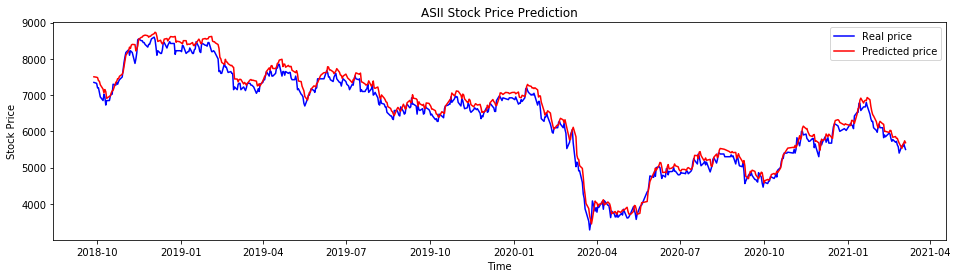

In [30]:
# Visualize the results by using Matplotlib
fig, ax = plt.subplots(figsize=(16, 4))
plt.plot(asii['Date'][4500:], dataset_test.values, color = 'blue', label = 'Real price')
plt.plot(asii['Date'][4500:], predicted_stock_price, color = 'red', label = 'Predicted price')
plt.title('ASII Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

Wow! Quite impressive!

The COVID-19 pandemic has started in January 2020. Therefore, there was a huge drop in ASII stock price in April 2020 due to the COVID-19 partial lockdown in several areas of Indonesia. It affects the performance of the company directly. After the implementation of health protocols in Indonesia, the stock market seems to bounce back on track. Hope the performance can be normal in the future or even better.

Let's evaluate this model now~

## 6. Evaluation

In [31]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

val_loss   val_mae   val_mse  val_accuracy      loss       mae       mse  \
95  0.000258  0.012131  0.000258           0.0  0.000602  0.018852  0.000602   
96  0.000319  0.013651  0.000319           0.0  0.000650  0.019622  0.000650   
97  0.000290  0.012983  0.000290           0.0  0.000620  0.019281  0.000620   
98  0.000382  0.015322  0.000382           0.0  0.000712  0.020574  0.000712   
99  0.000476  0.018011  0.000476           0.0  0.000725  0.020499  0.000725   

    accuracy  epoch  
95  0.000901     95  
96  0.000901     96  
97  0.000901     97  
98  0.000901     98  
99  0.000901     99

In [32]:
print(history.history.keys())

dict_keys(['val_loss', 'val_mae', 'val_mse', 'val_accuracy', 'loss', 'mae', 'mse', 'accuracy'])


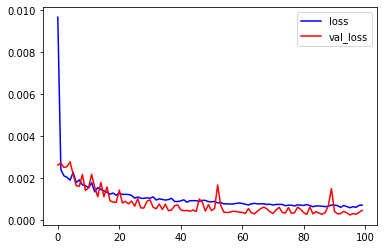

In [33]:
# Loss Graph
plt.plot(history.epoch, history.history['loss'] , label = "loss", color = 'blue')
plt.plot(history.epoch, history.history['val_loss'] , label = "val_loss", color = 'red')
plt.legend()
plt.show()

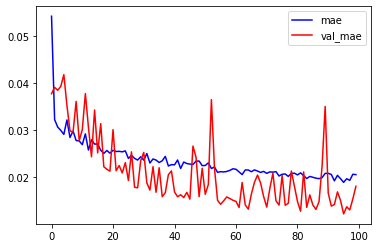

In [34]:
# Mean Absolute Error (MAE) Graph
plt.plot(history.epoch, history.history['mae'] , label="mae", color = 'blue')
plt.plot(history.epoch, history.history['val_mae'] , label = "val_mae", color = 'red')
plt.legend()
plt.show()

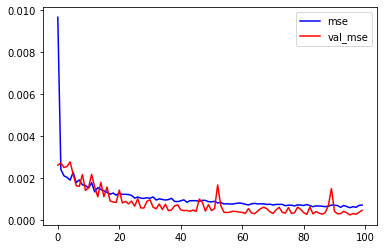

In [35]:
# Mean Squared Error (MSE) Graph
plt.plot(history.epoch, history.history['mse'] , label="mse", color = 'blue')
plt.plot(history.epoch, history.history['val_mse'] , label = "val_mse", color = 'red')
plt.legend()
plt.show()

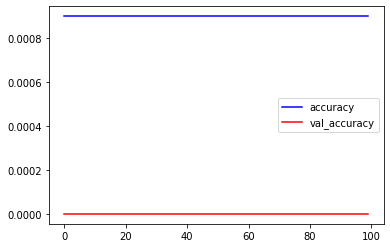

In [36]:
# Accuracy Graph
plt.plot(history.epoch, history.history['accuracy'] , label="accuracy", color = 'blue')
plt.plot(history.epoch, history.history['val_accuracy'] , label = "val_accuracy", color = 'red')
plt.legend()
plt.show()

Noice! the validation accuracy is even lower than the train accuracy.

In [37]:
# Now evaluating the model
print('Evaluate on test data')
score = model.evaluate(X_test, y_test, batch_size=16, verbose = 0)
print("%s: %.2f%%" % ("loss", score[0]*100))
print("%s: %.2f%%" % ("mae", score[1]*100))
print("%s: %.2f%%" % ("mse", score[2]*100))
print("%s: %.2f%%" % ("acc", score[3]*100))
#print("test loss, test mae, test mse, test acc:", score)

Evaluate on test data
loss: 0.05%
mae: 1.80%
mse: 0.05%
acc: 0.00%


## Conclusion

Here are some conclusions that we can draw after evaluating the result:

1. LSTM Network can accurately predict the stock price time-series data of Astra because it has a unique formulation that allows it to avoid the problems that prevent the training and scaling of other RNNs

2. The model will generalize better and accurately for the new data if we feed a larger train set to the model.

3. Data visualization helps in analyzing the stock price; thus, the right decisions can be formulated.

Future development: training different time-series models to predict the stock price and compare the result of the different models.

## 7. Deployment

In this stock prediction project, we did not go into the deployment part.

Note that in this part you will have to apply the conclusion to the business domain. Several activities should be conducted in this phase as below:
1. Plan deployment
2. Plan monitoring and maintenance
3. Produce final report
4. Review project

### References

1. Astra International. (2021) About Astra. URL: https://www.astra.co.id/About-Astra
2. Bao, Wei, Yue, Jun & Rao, Yulei. (2017). A deep learning framework for financial time series using stacked autoencoders and long-short term memory. PloS one, 12(7), p.e0180944.
3. Brownlee, J. (2017) Long Short-Term Memory Networks With Python Develop Sequence Prediction Models with Deep Learning. Machine Learning Mastery, EBook.
4. Brownlee, J. (2018) How to Develop LSTM Models for Time Series Forecasting. URL: https://machinelearningmastery.com/how-to-develop-lstm-models-for-time-series-forecasting/
5. Chapman, P., Clinton, J., Kerber, R., Khabaza, T., Shearer, C., & Wirth, R. (2000). CRISP-DM 1.0: Step-by-step data mining guide. In The CRISP-DM consortium.
6. Indonesia-Investment.com. (2014) Astra International. URL: https://www.indonesia-investments.com/business/indonesian-companies/astra-international/item192
7. Loukas, S. (2020) Time-Series Forecasting: Prediction Stock Prices Using An LSTM Model. URL: https://towardsdatascience.com/lstm-time-series-forecasting-predicting-stock-prices-using-an-lstm-model-6223e9644a2f 
8. Pai, Ping-Feng & Lin, Chih-Sheng. (2005). A hybrid ARIMA and support vector machines model in stock price forecasting. Omega (Oxford), 33(6), pp.497–505.
9. Papacharalampous, Georgia, Tyralis, Hristos & Koutsoyiannis, Demetris. (2018). Predictability of monthly temperature and precipitation using automatic time series forecasting methods. Acta geophysica, 66(4), pp.807–831.
10. Plotly. (2021). Plotly Python Open Source Graphing Library Financial Charts. URL: https://plotly.com/python/financial-charts/